In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
!mkdir -p /root/.kaggle

In [ ]:
!echo '{"username":"username","key":"API-KEY"}' > /root/.kaggle/kaggle.json

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
 89% 933M/1.03G [00:11<00:02, 45.2MB/s]
100% 1.03G/1.03G [00:11<00:00, 98.7MB/s]


In [ ]:
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [ ]:
IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 10
SEED = 42
data_dir = "asl_alphabet_train/asl_alphabet_train"

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(64, 64),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(64, 64),
    batch_size=32
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes:", num_classes)
print(class_names)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
Classes: 29
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_train(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = data_augmentation(image, training=True)
    return image, label

def preprocess_val(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess_train, num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(preprocess_val, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64, 64, 3)),

    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281,501 (4.89 MB)

 Trainable params: 1,281,053 (4.89 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.1911 - loss: 2.8182 - val_accuracy: 0.4359 - val_loss: 1.9063
Epoch 2/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 80s 37ms/step - accuracy: 0.5404 - loss: 1.3481 - val_accuracy: 0.8424 - val_loss: 0.4534
Epoch 3/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 85s 38ms/step - accuracy: 0.7088 - loss: 0.8424 - val_accuracy: 0.7899 - val_loss: 0.6256
Epoch 4/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.7869 - loss: 0.6178 - val_accuracy: 0.8658 - val_loss: 0.3696
Epoch 5/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 79s 36ms/step - accuracy: 0.8343 - loss: 0.4899 - val_accuracy: 0.9228 - val_loss: 0.2122
Epoch 6/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 79s 36ms/step - accuracy: 0.8624 - loss: 0.4066 - val_accuracy: 0.8602 - val_loss: 0.4823
Epoch 7/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.8868 - loss: 0.3405 - val_accuracy: 0.9356 - val_loss: 0.1908
Epoch 8/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.8973 -

In [ ]:
for images, labels in val_ds.take(1):
    preds = model.predict(images[:1])
    print("Prediction shape:", preds.shape)
    print("Predicted class:", class_names[np.argmax(preds)])
    print("True class:", class_names[labels[0].numpy()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Prediction shape: (1, 29)
Predicted class: V
True class: V


In [ ]:
print("Confidence:", np.max(preds))

Confidence: 1.0


In [ ]:
model.save("asl_model.h5")

import json
with open("class_names.json", "w") as f:
    json.dump(class_names, f)

In [ ]:
loaded_model = tf.keras.models.load_model("asl_model.h5")

for images, labels in val_ds.take(1):
    preds = loaded_model.predict(images[:1])
    print("Reload test OK:", preds.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
Reload test OK: (1, 29)


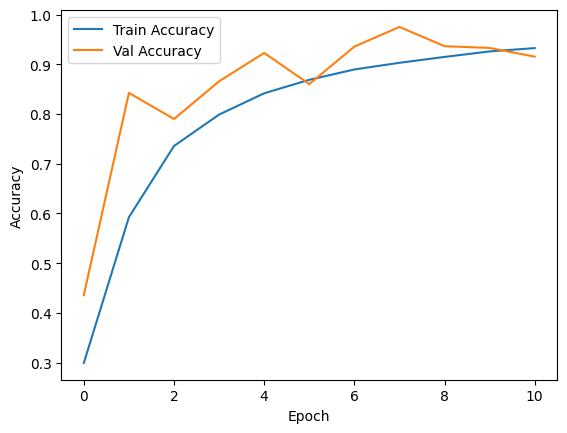

In [ ]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()